# Time series clustering exercise

In [33]:
from __future__ import print_function, division
import pandas as pd
import os
import requests
import shapely
import json
import urllib
from fiona.crs import from_epsg
import scipy as sp
from scipy import stats
import geopandas as gpd


In [34]:
import pandas as pd
import numpy as np
#import urllib
import urllib.request as urllib
import requests
import os
import io
import json
import pylab as pl
import shapely
from fiona.crs import from_epsg
import zipfile 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 

import scipy.cluster as scp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
import pandas as pd
import zipfile 

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [27]:
! $PUIDATA

/bin/sh: 1: /nfshome/mv1742/PUIdata: Permission denied


In [37]:
url = " https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"


In [39]:
#urllib.request.urlretrieve(url, "NYCSHAPEFILES.gz")

In [30]:
#! $PUIDATA/parksfiles
#!unzip -d $PUIDATA/parksfiles NYCSHAPEFILES.gz

In [ ]:
# fname=os.getenv("PUIDATA") + 
#                   "/parksfiles
# zf = zipfile.ZipFile(fname)
# df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))

In [ ]:
# import pandas as pd
# import zipfile 

# zf = zipfile.ZipFile(fname)
# df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
#sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)
N.shape = [250,20]

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [40]:

nyc_zipcodes = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/" + 
                                     "/parksfiles/ZIP_CODE_040114.shp")

(905410.75604293647,
 1075212.5382562785,
 112386.35181947277,
 280345.45402395504)

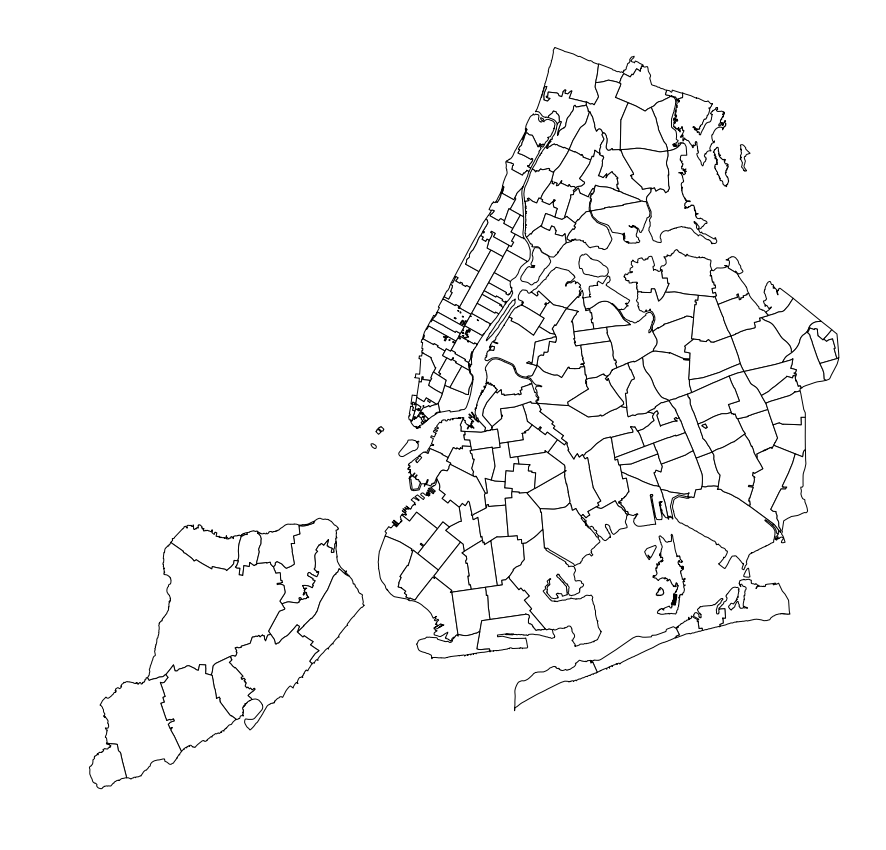

In [41]:
#fig = plt.figure(figsize=(10,4))
nyc_zipcodes.plot(figsize=(20,15), color='white', edgecolor='black')
plt.axis('off')

In [42]:
#PUIDATA

In [43]:
zip_list = ['/zbp00totals.zip',
        '/zbp01totals.zip',
        '/zbp02totals.zip',
        '/zbp03totals.zip',
        '/zbp04totals.zip',
        '/zbp05totals.zip',
        '/zbp06totals.zip',
        '/zbp07totals.zip',
        '/zbp08totals.zip',
        '/zbp09totals.zip',
        '/zbp10totals.zip',
        '/zbp11totals.zip',
        '/zbp12totals.zip',
        '/zbp13totals.zip',
        '/zbp94totals.zip',
        '/zbp95totals.zip',
        '/zbp96totals.zip',
        '/zbp97totals.zip',
        '/zbp98totals.zip',
        '/zbp99totals.zip']

for i in zip_list:
    
    urllib.urlretrieve('https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55' + i,
                   os.getenv("PUIDATA") + i)
    zip_ref = zipfile.ZipFile(os.getenv("PUIDATA") + i, 'r')
    zip_ref.extractall(os.getenv("PUIDATA"))
    zip_ref.close()

In [44]:
df = pd.read_csv(os.getenv("PUIDATA") + '/zbp94totals.txt')

#df.shape
#df.columns

# keep only zipcodes and # of establishments
df = df[['zip', 'est']]
#df.shape

zip_txt = ['/zbp95totals.txt',
           '/zbp96totals.txt',
           '/zbp97totals.txt',
           '/zbp98totals.txt',
           '/zbp99totals.txt',
           '/zbp00totals.txt',
           '/zbp01totals.txt',
           '/zbp02totals.txt',
           '/zbp03totals.txt',
           '/zbp04totals.txt',
           '/zbp05totals.txt',
           '/zbp06totals.txt',
           '/zbp07totals.txt',
           '/zbp08totals.txt',
           '/zbp09totals.txt',
           '/zbp10totals.txt',
           '/zbp11totals.txt',
           '/zbp12totals.txt',
           '/zbp13totals.txt']

for i in zip_txt:
    df_95_13 = pd.read_csv(os.getenv("PUIDATA") + i)
    df_95_13.columns = df_95_13.columns.str.lower() # convert to strings
    df_95_13 = df_95_13[['zip', 'est']]
    df = df.join(df_95_13.set_index('zip'), on='zip', how='outer', rsuffix=i) # change this?

In [45]:
df = df.rename(columns={'est':'1994',
                  'est/zbp95totals.txt':'1995',
                  'est/zbp96totals.txt':'1996',
                  'est/zbp97totals.txt':'1997',
                  'est/zbp98totals.txt':'1998',
                  'est/zbp99totals.txt':'1999',
                  'est/zbp00totals.txt':'2000',
                  'est/zbp01totals.txt':'2001',
                  'est/zbp02totals.txt':'2002',
                  'est/zbp03totals.txt':'2003',
                  'est/zbp04totals.txt':'2004',
                  'est/zbp05totals.txt':'2005',
                  'est/zbp06totals.txt':'2006',
                  'est/zbp07totals.txt':'2007',
                  'est/zbp08totals.txt':'2008',
                  'est/zbp09totals.txt':'2009',
                  'est/zbp10totals.txt':'2010',
                  'est/zbp11totals.txt':'2011',
                  'est/zbp12totals.txt':'2012',
                  'est/zbp13totals.txt':'2013'})
df.head()

zip   1994   1995   1996   1997   1998   1999   2000   2001   2002  \
0  1001.0  439.0  439.0  433.0  457.0  444.0  469.0  493.0  490.0  490.0   
1  1002.0  450.0  467.0  487.0  500.0  490.0  558.0  563.0  587.0  566.0   
2  1003.0   10.0   10.0   13.0   15.0   14.0   13.0   13.0   13.0   15.0   
3  1004.0   47.0   48.0   47.0   41.0   31.0   35.0   48.0   37.0   23.0   
4  1005.0   92.0   95.0  101.0  104.0   95.0   82.0   86.0   90.0   94.0   

   ...     2004   2005   2006   2007   2008   2009   2010   2011   2012   2013  
0  ...    500.0  509.0  509.0  503.0  477.0  458.0  448.0  436.0  453.0  439.0  
1  ...    584.0  589.0  582.0  596.0  584.0  571.0  570.0  558.0  572.0  572.0  
2  ...     15.0   12.0   12.0   16.0   17.0   16.0   16.0   16.0   15.0   15.0  
3  ...     43.0   31.0   30.0   20.0   18.0   18.0   21.0   19.0   16.0   16.0  
4  ...     97.0   94.0   98.0  106.0   97.0   87.0   96.0   91.0   94.0   97.0  

[5 rows x 21 columns]

In [46]:
print(df.shape)

(42653, 21)


In [47]:
zipshp = nyc_zipcodes


In [48]:
zipshp.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 13 columns):
ZIPCODE       263 non-null object
BLDGZIP       263 non-null object
PO_NAME       263 non-null object
POPULATION    263 non-null float64
AREA          263 non-null float64
STATE         263 non-null object
COUNTY        263 non-null object
ST_FIPS       263 non-null object
CTY_FIPS      263 non-null object
URL           263 non-null object
SHAPE_AREA    263 non-null float64
SHAPE_LEN     263 non-null float64
geometry      263 non-null object
dtypes: float64(4), object(9)
memory usage: 26.8+ KB


In [49]:
import geopandas as gp
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/parksfiles/ZIP_CODE_040114.shp")
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [50]:
zipshp['ZIPCODE'] = pd.to_numeric(zipshp['ZIPCODE'])


In [51]:

zipshp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 13 columns):
ZIPCODE       263 non-null int64
BLDGZIP       263 non-null object
PO_NAME       263 non-null object
POPULATION    263 non-null float64
AREA          263 non-null float64
STATE         263 non-null object
COUNTY        263 non-null object
ST_FIPS       263 non-null object
CTY_FIPS      263 non-null object
URL           263 non-null object
SHAPE_AREA    263 non-null float64
SHAPE_LEN     263 non-null float64
geometry      263 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 26.8+ KB


In [52]:
# Merge the geopandas dataframe and the establishments dataframe

nyc_establishments = pd.merge(zipshp[['ZIPCODE']], df, left_on='ZIPCODE', right_on='zip', how='left')
nyc_establishments = nyc_establishments.drop(['zip'], axis = 1)
nyc_establishments = nyc_establishments.dropna()
nyc_establishments.head(2)

ZIPCODE   1994   1995   1996   1997   1998   1999   2000   2001   2002  \
0    11436   51.0   50.0   53.0   51.0   51.0   58.0   65.0   57.0   78.0   
1    11213  406.0  420.0  433.0  456.0  476.0  473.0  477.0  493.0  546.0   

   ...     2004   2005   2006   2007   2008   2009   2010   2011   2012   2013  
0  ...     84.0   82.0   80.0   84.0   90.0   92.0   98.0  101.0   95.0   99.0  
1  ...    570.0  556.0  565.0  556.0  592.0  621.0  675.0  674.0  726.0  755.0  

[2 rows x 21 columns]

In [53]:
zips = nyc_establishments[['ZIPCODE']]
zips.head()

ZIPCODE
0    11436
1    11213
2    11212
3    11225
4    11218

In [54]:
mask = nyc_establishments.drop(['ZIPCODE'], axis=1)
mask.head()

1994    1995    1996    1997    1998    1999    2000    2001    2002  \
0   51.0    50.0    53.0    51.0    51.0    58.0    65.0    57.0    78.0   
1  406.0   420.0   433.0   456.0   476.0   473.0   477.0   493.0   546.0   
2  505.0   494.0   502.0   527.0   519.0   541.0   520.0   527.0   577.0   
3  381.0   387.0   388.0   410.0   416.0   409.0   417.0   422.0   479.0   
4  985.0  1015.0  1049.0  1075.0  1118.0  1149.0  1161.0  1180.0  1228.0   

     2003    2004    2005    2006    2007    2008    2009    2010    2011  \
0    74.0    84.0    82.0    80.0    84.0    90.0    92.0    98.0   101.0   
1   569.0   570.0   556.0   565.0   556.0   592.0   621.0   675.0   674.0   
2   581.0   586.0   587.0   570.0   587.0   602.0   647.0   699.0   713.0   
3   488.0   492.0   491.0   499.0   514.0   520.0   543.0   580.0   597.0   
4  1247.0  1295.0  1332.0  1331.0  1377.0  1397.0  1457.0  1474.0  1523.0   

     2012    2013  
0    95.0    99.0  
1   726.0   755.0  
2   721.0   731.0  
3   623.0   673.0  
4  1605.0  1687.0

In [55]:
# Standardizing
vals = ((mask.T - mask.mean(1)) / mask.std(1)).T
vals.head()

1994      1995      1996      1997      1998      1999      2000  \
0 -1.279776 -1.333890 -1.171550 -1.279776 -1.279776 -0.900984 -0.522192   
1 -1.452072 -1.312784 -1.183446 -0.954616 -0.755634 -0.785482 -0.745685   
2 -1.063574 -1.206598 -1.102581 -0.777527 -0.881544 -0.595498 -0.868542   
3 -1.245223 -1.174371 -1.162563 -0.902772 -0.831920 -0.914581 -0.820112   
4 -1.504638 -1.353797 -1.182844 -1.052115 -0.835910 -0.680041 -0.619705   

       2001      2002      2003      2004      2005      2006      2007  \
0 -0.955097  0.181279 -0.035174  0.505958  0.397732  0.289505  0.505958   
1 -0.586500 -0.059197  0.169632  0.179581  0.040294  0.129836  0.040294   
2 -0.777527 -0.127421 -0.075412 -0.010402  0.002600 -0.218436  0.002600   
3 -0.761068 -0.087975  0.018303  0.065538  0.053729  0.148199  0.325329   
4 -0.524172 -0.282827 -0.187294  0.054051  0.240088  0.235060  0.466350   

       2008      2009      2010      2011      2012      2013  
0  0.830637  0.938863  1.263543  1.425882  1.101203  1.317656  
1  0.398462  0.686986  1.224237  1.214288  1.731641  2.020165  
2  0.197632  0.782728  1.458839  1.640869  1.744886  1.874907  
3  0.396181  0.667780  1.104700  1.305447  1.612473  2.202906  
4  0.566910  0.868592  0.954069  1.200442  1.612741  2.025039

In [56]:
#cluster with kmeans
km = KMeans(n_clusters=4, random_state=444).fit(vals)

In [57]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(243,)

In [58]:
km.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 2, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 2,
       2, 0, 0, 2, 1, 2, 1, 2, 1, 1, 1, 3, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 1,
       2, 2, 1, 0, 2, 1, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 3,
       3, 2, 2, 1, 1, 1, 1, 3, 3, 0, 1, 3, 1], dtype=int32)

In [59]:
vals['Cluster_Number'] = km.labels_
vals.head()

1994      1995      1996      1997      1998      1999      2000  \
0 -1.279776 -1.333890 -1.171550 -1.279776 -1.279776 -0.900984 -0.522192   
1 -1.452072 -1.312784 -1.183446 -0.954616 -0.755634 -0.785482 -0.745685   
2 -1.063574 -1.206598 -1.102581 -0.777527 -0.881544 -0.595498 -0.868542   
3 -1.245223 -1.174371 -1.162563 -0.902772 -0.831920 -0.914581 -0.820112   
4 -1.504638 -1.353797 -1.182844 -1.052115 -0.835910 -0.680041 -0.619705   

       2001      2002      2003       ...            2005      2006      2007  \
0 -0.955097  0.181279 -0.035174       ...        0.397732  0.289505  0.505958   
1 -0.586500 -0.059197  0.169632       ...        0.040294  0.129836  0.040294   
2 -0.777527 -0.127421 -0.075412       ...        0.002600 -0.218436  0.002600   
3 -0.761068 -0.087975  0.018303       ...        0.053729  0.148199  0.325329   
4 -0.524172 -0.282827 -0.187294       ...        0.240088  0.235060  0.466350   

       2008      2009      2010      2011      2012      2013  Cluster_Number  
0  0.830637  0.938863  1.263543  1.425882  1.101203  1.317656               1  
1  0.398462  0.686986  1.224237  1.214288  1.731641  2.020165               1  
2  0.197632  0.782728  1.458839  1.640869  1.744886  1.874907               1  
3  0.396181  0.667780  1.104700  1.305447  1.612473  2.202906               1  
4  0.566910  0.868592  0.954069  1.200442  1.612741  2.025039               1  

[5 rows x 21 columns]

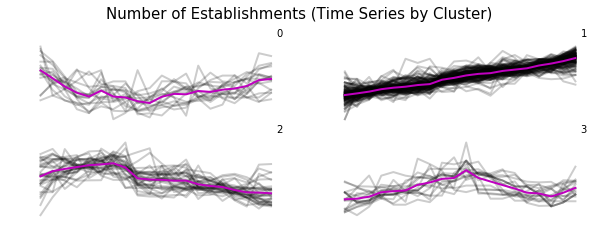

In [60]:

plt.figure(figsize=(10,5))
plt.suptitle('Number of Establishments (Time Series by Cluster)', fontsize=15)
n=320
for x in range(4):
    n+=1
    plt.subplot(n)
    seg = vals[vals.Cluster_Number == x]
    for i in range(len(seg)):
        plt.plot(range(1994,2014), seg.iloc[i][0:-1], c='k', alpha=0.2, linewidth=2)
    plt.plot(range(1994,2014), seg.mean()[0:-1], c='m', alpha=1, linewidth=2)
    plt.axis('off')
    plt.title('{}'.format(x), fontsize=10, loc='right')

In [61]:
# Prepare of dataframe that has geometries and cluster numbers

clean = zips.join(vals)
clean = clean[['ZIPCODE', 'Cluster_Number']]

map_df = zipshp.merge(clean, on='ZIPCODE', how='left')
map_df.head()

ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0    11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1    11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2    11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3    11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4    11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  Cluster_Number  
0  POLYGON ((1038098.251871482 188138.3800067157,...             1.0  
1  POLYGON ((1001613.712964058 186926.4395172149,...             1.0  
2  POLYGON ((1011174.275535807 183696.33770971, 1...             1.0  
3  POLYGON ((995908.3654508889 183617.6128015518,...             1.0  
4  POLYGON ((991997.1134308875 176307.4958601296,...             1.0

In [62]:
map_df.dropna(how='all', inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


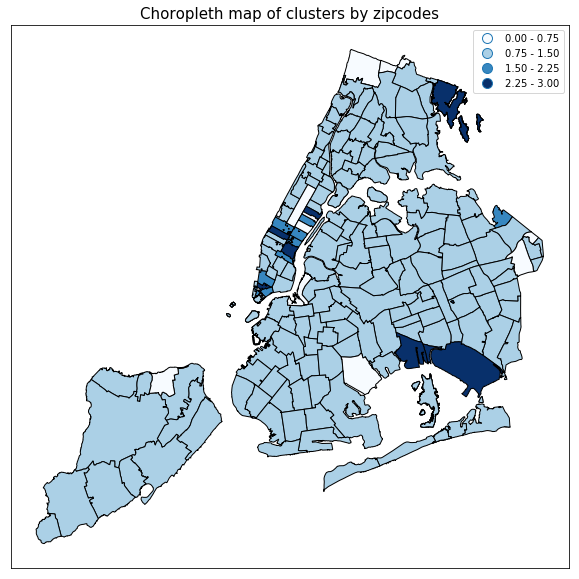

In [63]:
# Chloropleuth map of clusters by zipcodes
fig, ax = plt.subplots(1, figsize=(10,10))
map_df.plot('Cluster_Number', ax=ax, legend=True, cmap='Blues', scheme='equal_interval', k=4, edgecolor='black')
plt.title('Choropleth map of clusters by zipcodes', fontsize=15)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Figure 2:
Choropleth of cluster centers for 4 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted in Figure 1. Note that the legend is somewhat misleading -- as Cluster is a categorical variable (and not continous). Here, the lightest color corresponds to Cluster 0, one shade above is Cluster 1, one shade above that one is Cluster 2 and the darkest one is Cluster 3.

In Figure 1, we noted that zipcodes in cluster 2 saw increases in the number of businesses. From this map, we can see that most of New York City saw increases in number of establishments. Particularly, all outer boroughs witnessed this trend. In Manhattan, there were some decreases in the Financial District and in Midtown.

In [64]:
vals.head()
agg_vals = vals.drop('Cluster_Number', axis=1)

In [65]:
type(vals)

pandas.core.frame.DataFrame

In [66]:
agc = AgglomerativeClustering(n_clusters=4, linkage='average').fit(agg_vals)
labelsag = agc.labels_
centroidsag = np.zeros((4, agg_vals.shape[1]))

In [67]:
agc.labels_


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0, 3, 0, 0, 2, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 0, 2,
       2, 2, 0, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1])

In [68]:
agg_vals['Agg_Cluster_Number'] = agc.labels_


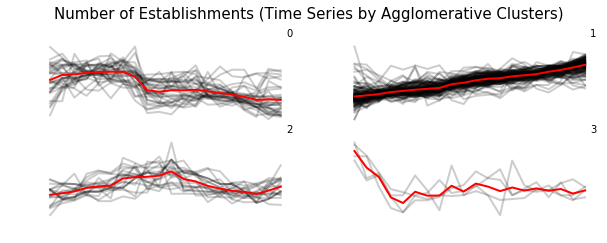

In [69]:
plt.figure(figsize=(10,5))
plt.suptitle('Number of Establishments (Time Series by Agglomerative Clusters)', fontsize=15)
n=320
for x in range(4):
    n+=1
    plt.subplot(n)
    seg = agg_vals[agg_vals.Agg_Cluster_Number == x]
    for i in range(len(seg)):
        plt.plot(range(1994,2014), seg.iloc[i][0:-1], c='k', alpha=0.2, linewidth=2)
    plt.plot(range(1994,2014), seg.mean()[0:-1], c='r', alpha=1, linewidth=2)
    plt.axis('off')
    plt.title('{}'.format(x), fontsize=10, loc='right')


## Figure 3. Time Series of Number of Establishments by Agglomerative Clusters
The red lines plot the means of 4 agglomerative clusters for the establishments in zipcodes. We can see that number of businesses increased in cluster 1 (and it also looks like the densest cluster similar to Cluster 2 in the previous graphs). We can see that the other 3 stayed about the same throughout the time series, but there are interesting drops in the beginning of Cluster 2 Time Series and in the middle of Cluster 3 Time Series.

In [71]:
# Prepare of dataframe that has geometries and cluster numbers

clean_2 = zips.join(agg_vals)
clean_2 = clean_2[['ZIPCODE', 'Agg_Cluster_Number']]

agg_map_df = zipshp.merge(clean_2, on='ZIPCODE', how='left')
agg_map_df.head()

ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0    11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1    11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2    11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3    11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4    11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  Agg_Cluster_Number  
0  POLYGON ((1038098.251871482 188138.3800067157,...                 1.0  
1  POLYGON ((1001613.712964058 186926.4395172149,...                 1.0  
2  POLYGON ((1011174.275535807 183696.33770971, 1...                 1.0  
3  POLYGON ((995908.3654508889 183617.6128015518,...                 1.0  
4  POLYGON ((991997.1134308875 176307.4958601296,...                 1.0

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


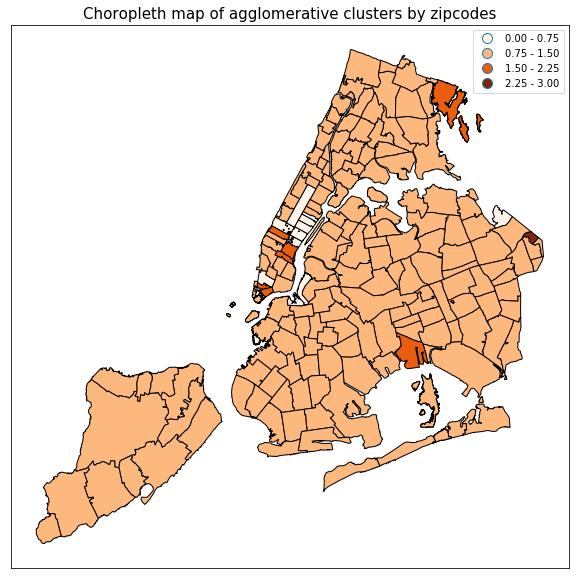

In [72]:
# Chloropleuth map of agglomerative clusters by zipcodes
fig, ax = plt.subplots(1, figsize=(10,10))

agg_map_df.plot('Agg_Cluster_Number', ax=ax, legend=True, 
            cmap='Oranges', scheme='equal_interval', k=4,
            edgecolor='black')
plt.title('Choropleth map of agglomerative clusters by zipcodes', fontsize=15)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#### Figure 4:
Choropleth of cluster centers for 4 agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top. Note that the legend is somewhat misleading -- as Cluster is a categorical variable (and not continous). Here, the lightest color corresponds to Cluster 0, one shade above is Cluster 1, one shade above that one is Cluster 2 and the darkest one is Cluster 3.

In Figure 3, we noted that zipcodes in cluster 1 saw increases in the number of businesses. From this map, we can see that most of New York City saw increases in number of establishments.

This is consistent with the findings we had after doing K-Means clustering

Comparison of findings from two clustering methods
The clustering methods gave us similar results in that both of them show a trend of increasing number of business for clusters that represent most of New York (outer boroughs and most of Manhattan).

Seemingly, K-Means produced more distinguished trends in Time Series, while agglomerative clustering produced some interesting drops in the beginning of Cluster 2 Time Series and in the middle of Cluster 3 Time Series. This would be interesting to explore in further analyses.